In [31]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from itertools import combinations
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
teams_abbr = {'- - -': '- - -', 'ANA': 'Angels', 'ARI': 'Diamondbacks', 
 'ATL': 'Braves', 'BAL': 'Orioles', 'BOS': 'Red Sox', 'CHC': 'Cubs', 
 'CHW': 'White Sox', 'CIN': 'Reds', 'CLE': 'Indians', 'COL': 'Rockies',
 'DET': 'Tigers', 'FLA': 'Marlins', 'HOU': 'Astros', 'KCR': 'Royals', 
 'LAA': 'Angels', 'LAD': 'Dodgers', 'MIA': 'Marlins', 'MIL': 'Brewers',
 'MIN': 'Twins', 'MON': 'Expos', 'NYM': 'Mets', 'NYY': 'Yankees',
 'OAK': 'Athletics', 'PHI': 'Phillies', 'PIT': 'Pirates', 'SDP': 'Padres',
 'SEA': 'Mariners', 'SFG': 'Giants', 'STL': 'Cardinals', 'TBD': 'Devil Rays', 
 'TBR': 'Rays', 'TEX': 'Rangers', 'TOR': 'Blue Jays', 'WSN': 'Nationals'}

In [3]:
#read in all data
sp = pd.read_csv('FanGraphs_Starters (2).csv')
rp = pd.read_csv('FanGraphs_Relievers (2).csv')
fd = pd.read_csv('FanGraphs_Fielders (2).csv')
bt = pd.read_csv('FanGraphs_Batting (2).csv')

a, b, c = len(sp),len(rp),len(fd)
print("""Number of starter pitchers:\t{}
Number of relief pitchers:\t{}
Number of fielders:\t\t{}
-------------------------------------
Total number of records:\t{}""".format(a, b, c, a+b+c))

#change abbreviation to full team name
fd.loc[[True]*len(fd),'Team'] = [teams_abbr[k] for k in fd.Team]



Number of starter pitchers:	2741
Number of relief pitchers:	1265
Number of fielders:		16122
-------------------------------------
Total number of records:	20128


In [4]:
bt.columns

Index(['Season', 'Name', 'Team', 'G', 'PA', 'HR', 'R', 'RBI', 'SB', 'BB%',
       'K%', 'ISO', 'BABIP', 'AVG', 'OBP', 'SLG', 'wOBA', 'wRC+', 'BsR', 'Off',
       'Def', 'WAR', 'playerid'],
      dtype='object')

In [5]:
rp.columns

Index(['Season', 'Name', 'Team', 'W', 'L', 'SV', 'G', 'GS', 'IP', 'K/9',
       'BB/9', 'HR/9', 'BABIP', 'LOB%', 'GB%', 'HR/FB', 'ERA', 'FIP', 'xFIP',
       'WAR', 'playerid'],
      dtype='object')

In [6]:
sp.columns

Index(['Season', 'Name', 'Team', 'W', 'L', 'SV', 'G', 'GS', 'IP', 'K/9',
       'BB/9', 'HR/9', 'BABIP', 'LOB%', 'GB%', 'HR/FB', 'ERA', 'FIP', 'xFIP',
       'WAR', 'playerid'],
      dtype='object')

In [7]:
print(fd.columns)
fd.sample(5)

Index(['Season', 'Name', 'Team', 'Pos', 'Inn', 'rSB', 'rGDP', 'rARM', 'rGFP',
       'rPM', 'DRS', 'BIZ', 'Plays', 'RZR', 'OOZ', 'CPP', 'RPP', 'TZL', 'FSR',
       'ARM', 'DPR', 'RngR', 'ErrR', 'UZR', 'UZR/150', 'Def', 'playerid'],
      dtype='object')


,Season,Name,Team,Pos,Inn,rSB,rGDP,rARM,rGFP,rPM,...,TZL,FSR,ARM,DPR,RngR,ErrR,UZR,UZR/150,Def,playerid
2548,2010,Eli Whiteside,Giants,C,340.2,1.0,NaN,NaN,-2,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3536
7826,2017,Kennys Vargas,Twins,1B,270.1,NaN,0.0,NaN,-1,4.0,...,NaN,NaN,NaN,-0.4,1.0,0.3,0.9,4.6,-1.4,12101
5069,2011,Rafael Furcal,Dodgers,SS,304.1,NaN,0.0,NaN,1,1.0,...,NaN,2.0,NaN,0.6,-1.5,-0.2,-1.1,-4.7,0.5,88
468,2017,Juan Lagares,Mets,CF,566.2,NaN,NaN,8.0,1,6.0,...,NaN,NaN,7.3,NaN,3.5,-0.4,10.4,24.7,11.4,5384
920,2006,Morgan Ensberg,Astros,3B,975.0,NaN,0.0,NaN,0,7.0,...,NaN,NaN,NaN,0.6,4.3,1.4,6.3,8.7,8.0,556


In [8]:
#create a 3 sets containing tuples of playerids with the season for each record
fd_season_id = set([tuple(row) for row in fd[['playerid','Season']].values])
rp_season_id = set([tuple(row) for row in rp[['playerid','Season']].values])
sp_season_id = set([tuple(row) for row in sp[['playerid','Season']].values])
bt_season_id = set([tuple(row) for row in bt[['playerid','Season']].values])

a, b, c = len(sp_season_id), len(rp_season_id), len(fd_season_id)
total = set()
total.update(sp_season_id);total.update(rp_season_id);total.update(fd_season_id)

print("Only counting players once per season.\n")
print("""Number of starter pitchers:\t{}
Number of relief pitchers:\t{}
Number of fielders:\t\t{}
-------------------------------------
Total number of records:\t{}""".format(a, b, c, len(total)))


Only counting players once per season.

Number of starter pitchers:	2675
Number of relief pitchers:	1265
Number of fielders:		12253
-------------------------------------
Total number of records:	12254


In [9]:
print(len(bt_season_id.intersection(fd_season_id)))
print(len(bt_season_id.intersection(rp_season_id)))
print(len(bt_season_id.intersection(sp_season_id)))
print(len(rp_season_id.intersection(fd_season_id)))
print(len(rp_season_id.intersection(sp_season_id)))
print(len(sp_season_id.intersection(fd_season_id)))


8157
0
590
1264
3
2675


In [10]:
#create temporary Seasonid column
fd.insert(2,'Seasonid',[tuple(row) for row in fd[['playerid','Season']].values])
rp.insert(2,'Seasonid',[tuple(row) for row in rp[['playerid','Season']].values])
sp.insert(2,'Seasonid',[tuple(row) for row in sp[['playerid','Season']].values])

#find and remove duplicates between dataframes
#mask = fd.Seasonid.isin(sp_season_id)
#fd.drop(fd[mask].index,inplace=True)

#mask = fd.Seasonid.isin(rp_season_id)
#fd.drop(fd[mask].index,inplace=True)

mask = rp.Seasonid.isin(sp_season_id)
rp.drop(rp[mask].index,inplace=True)

#remove temporary Seasonid column
fd.drop('Seasonid',axis=1,inplace=True)
sp.drop('Seasonid',axis=1,inplace=True)
rp.drop('Seasonid',axis=1,inplace=True)

In [11]:
#change all fielder positions (except catcher) to FD
fd.loc[fd.Pos.isin(['1B','2B','3B','RF','LF','CF','SS']),'Pos'] = 'FD'

#add column with potision to prepare for combining data
sp.insert(2, 'Pos', 'P')
rp.insert(2,'Pos', 'P')

In [12]:
p = pd.concat([sp,rp,fd], ignore_index=True)
#p = pd.merge(sp,rp, on=['Season', 'Name']'Seasonid', how='outer')
#p = pd.merge(p, fd, on='Seasonid', how='outer')
p.drop(p[p.Season<2002].index,inplace=True)
p.reset_index()

p.sample(5)

,ARM,BABIP,BB/9,BIZ,CPP,DPR,DRS,Def,ERA,ErrR,...,UZR/150,W,WAR,playerid,rARM,rGDP,rGFP,rPM,rSB,xFIP
8981,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.6,NaN,NaN,...,NaN,NaN,NaN,514,NaN,NaN,0.0,NaN,0.0,NaN
10580,1.2,NaN,NaN,31.0,NaN,NaN,3.0,-0.5,NaN,0.3,...,3.9,NaN,NaN,3123,2.0,NaN,0.0,1.0,NaN,NaN
7870,0.0,NaN,NaN,47.0,NaN,NaN,3.0,1.4,NaN,0.5,...,14.7,NaN,NaN,7287,1.0,NaN,0.0,2.0,NaN,NaN
7308,NaN,NaN,NaN,323.0,NaN,1.1,-14.0,2.0,NaN,2.2,...,-4.1,NaN,NaN,1079,NaN,1.0,-1.0,-14.0,NaN,NaN
6235,0.3,NaN,NaN,170.0,NaN,NaN,-4.0,3.6,NaN,0.1,...,13.8,NaN,NaN,369,-1.0,NaN,1.0,-4.0,NaN,NaN


In [13]:
p = p.drop(['rSB', 'rGDP', 'rARM', 'rGFP',
       'rPM', 'BIZ', 'Plays', 'RZR', 'OOZ', 'CPP', 'TZL', 'FSR',
       'ARM', 'DPR', 'RngR', 'ErrR', 'UZR/150', 'Def',
        'L', 'SV', 'G', 'GS', 'IP', 'K/9',
       'BB/9', 'HR/9', 'BABIP', 'LOB%', 'GB%', 'HR/FB', 'ERA', 'xFIP',
       ], axis=1)

In [14]:
p['DRS'].fillna(p['DRS'].mean(), inplace=True)
p['RPP'].fillna(p['RPP'].mean(), inplace=True)
p['UZR'].fillna(p['UZR'].mean(), inplace=True)
p['FIP'].fillna(p['FIP'].mean(), inplace=True)
p['Inn'].fillna(p['Inn'].mean(), inplace=True)
p['WAR'].fillna(p['WAR'].mean(), inplace=True)
p['W'].fillna(p['W'].mean(), inplace=True)


In [15]:
by_pos = p.groupby('Pos')
for g in by_pos.groups:
    group = by_pos.get_group(g)
    print('#'*50)
    print(g)
    for c in p.columns:
        print(c,'\t', len(group)-group[c].count())

##################################################
FD
DRS 	 0
FIP 	 0
Inn 	 0
Name 	 0
Pos 	 0
RPP 	 0
Season 	 0
Team 	 0
UZR 	 0
W 	 0
WAR 	 0
playerid 	 0
##################################################
P
DRS 	 0
FIP 	 0
Inn 	 0
Name 	 0
Pos 	 0
RPP 	 0
Season 	 0
Team 	 0
UZR 	 0
W 	 0
WAR 	 0
playerid 	 0
##################################################
C
DRS 	 0
FIP 	 0
Inn 	 0
Name 	 0
Pos 	 0
RPP 	 0
Season 	 0
Team 	 0
UZR 	 0
W 	 0
WAR 	 0
playerid 	 0


In [16]:
#account for team name changes
p.loc[p.Team=='Devil Rays','Team'] = 'Rays'
p.loc[p.Team=='Expos','Team'] = 'Nationals'
del(teams_abbr['MON'])
del(teams_abbr['TBD'])

#delete players from a season if their team is unknown
p.drop(p[p.Team=='- - -'].index,inplace=True)
del(teams_abbr['- - -'])

In [17]:
print("Number of records before:\t{}".format(len(p)))
p.drop_duplicates(inplace=True)
print("Number of records after:\t{}".format(len(p)))

Number of records before:	20125
Number of records after:	20125


In [18]:
p.sample(5)

,DRS,FIP,Inn,Name,Pos,RPP,Season,Team,UZR,W,WAR,playerid
19156,-3.000000,4.051089,60.0000,Justin Wilson,P,0.018954,2014,Pirates,0.053147,7.436672,1.598176,4301
770,0.076789,3.890000,364.8328,Zach Davies,P,0.018954,2016,Brewers,0.053147,11.000000,2.700000,13183
1247,0.076789,4.110000,364.8328,Wily Peralta,P,0.018954,2014,Brewers,0.053147,17.000000,1.800000,7738
12243,-2.000000,4.051089,89.0000,Geoff Blum,FD,0.018954,2005,White Sox,-0.900000,7.436672,1.598176,550
12571,-3.000000,4.051089,78.1000,Nate McLouth,FD,0.018954,2014,Nationals,-1.600000,7.436672,1.598176,3190


In [19]:
p.dropna(axis=1, how='any')

,DRS,FIP,Inn,Name,Pos,RPP,Season,Team,UZR,W,WAR,playerid
0,0.076789,2.300000,364.8328,Randy Johnson,P,0.018954,2004,Diamondbacks,0.053147,16.000000,9.600000,60
1,0.076789,2.350000,364.8328,Curt Schilling,P,0.018954,2002,Diamondbacks,0.053147,23.000000,9.400000,73
2,0.076789,2.330000,364.8328,Zack Greinke,P,0.018954,2009,Royals,0.053147,16.000000,8.600000,1943
3,0.076789,1.990000,364.8328,Clayton Kershaw,P,0.018954,2015,Dodgers,0.053147,16.000000,8.500000,2036
4,0.076789,2.200000,364.8328,Roy Halladay,P,0.018954,2011,Phillies,0.053147,19.000000,8.300000,1303
5,0.076789,2.660000,364.8328,Randy Johnson,P,0.018954,2002,Diamondbacks,0.053147,24.000000,8.100000,60
6,0.076789,2.650000,364.8328,Ben Sheets,P,0.018954,2004,Brewers,0.053147,12.000000,8.000000,710
7,0.076789,2.470000,364.8328,Mark Prior,P,0.018954,2003,Cubs,0.053147,18.000000,7.800000,301
8,0.076789,2.800000,364.8328,Justin Verlander,P,0.018954,2009,Tigers,0.053147,19.000000,7.700000,8700
9,0.076789,2.340000,364.8328,Tim Lincecum,P,0.018954,2009,Giants,0.053147,15.000000,7.700000,5705


In [20]:
if 'Change_Type' in p.columns:
    p.drop('Change_Type', axis=1, inplace=True)
    
    
#initialize the new column with value 'No Change'
p.insert(1, 'Leave', 0)
by_player = p.groupby('playerid')

#loop through, player by player
for g in by_player.groups:
    one_p = by_player.get_group(g)
    
    #loop through the years for each player
    for y in sorted(one_p['Season'])[1:]:
        
        #Case: no change
        if sum(one_p.Season==y-1)==0: continue
        
        #Case: arrive
        if (one_p[one_p.Season==y].Team.values[0] != 
        one_p[one_p.Season==y-1].Team.values[0]):
            
            #Case: arrive and previous arrive/leave
            if (p[(p.Season==y-1)&(p.playerid==g)]['Leave'].values[0]
            == 'Arrive'):
                p.loc[one_p[one_p.Season==y-1].index,'Leave'] = 1
                p.loc[one_p[one_p.Season==y].index,'Leave'] = 0
                
            
            #Case: arrive and previous leave
            else:
                p.loc[one_p[one_p.Season==y-1].index,'Leave'] = 1
                p.loc[one_p[one_p.Season==y].index,'Leave'] = 0

In [21]:
p.sample(5)

,DRS,Leave,FIP,Inn,Name,Pos,RPP,Season,Team,UZR,W,WAR,playerid
2539,0.076789,0,4.960000,364.8328,Randall Delgado,P,0.018954,2013,Diamondbacks,0.053147,5.000000,0.000000,5985
15716,1.000000,0,4.051089,1207.1000,Phil Nevin,FD,0.018954,2004,Padres,-5.000000,7.436672,1.598176,1049
3912,0.076789,1,4.720000,364.8328,Josh Roenicke,P,0.018954,2012,Rockies,0.053147,4.000000,-0.200000,3241
18551,-1.000000,0,4.051089,138.1000,Marco Estrada,P,0.018954,2012,Brewers,0.053147,7.436672,1.598176,1118
18105,-3.000000,0,4.051089,77.2000,Carlos Marmol,P,0.018954,2010,Cubs,0.053147,7.436672,1.598176,2790


In [23]:
#p.drop(['P', 'C', 'FD'], axis=1, inplace=True)
p.insert(0, 'P', (p.Pos=='P').apply(int))
p.insert(0, 'C', (p.Pos=='C').apply(int))
p.insert(0, 'FD', (p.Pos=='FD').apply(int))

p.sample(5)

,FD,C,P,DRS,Leave,FIP,Inn,Name,Pos,RPP,Season,Team,UZR,W,WAR,playerid
8894,1,0,0,0.0,0,4.051089,149.1,Orlando Palmeiro,FD,0.018954,2005,Astros,1.400000,7.436672,1.598176,28
16108,0,0,1,0.0,1,4.051089,75.0,Wilson Alvarez,P,0.018954,2002,Rays,0.053147,7.436672,1.598176,1193
9043,0,1,0,-15.0,0,4.051089,1110.0,Victor Martinez,C,0.018954,2006,Indians,0.053147,7.436672,1.598176,393
7744,1,0,0,2.0,0,4.051089,341.2,Josh Harrison,FD,0.018954,2017,Pirates,0.900000,7.436672,1.598176,8202
18212,0,0,1,-1.0,0,4.051089,61.0,Trevor Bell,P,0.018954,2010,Angels,0.053147,7.436672,1.598176,7074


In [34]:
temp = p[['FD', 'C', 'P', 'Inn', 'W', 'WAR', 'DRS', 'RPP', 'UZR', 'FIP']]
temp['P*WAR'] = temp['P']*temp['WAR']
temp['P*FIP'] = temp['P']*temp['FIP']
temp['FD*UZR'] = temp['FD']*temp['UZR']
temp['C*DRS'] = temp['C']*temp['DRS']

X = temp[['FD', 'C', 'P', 'Inn', 'W', 'P*WAR', 'C*DRS', 'RPP', 'FD*UZR', 'P*FIP']]

y = p['Leave']

X

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,FD,C,P,Inn,W,P*WAR,C*DRS,RPP,FD*UZR,P*FIP
0,0,0,1,364.8328,16.000000,9.600000,0.0,0.018954,0.0,2.300000
1,0,0,1,364.8328,23.000000,9.400000,0.0,0.018954,0.0,2.350000
2,0,0,1,364.8328,16.000000,8.600000,0.0,0.018954,0.0,2.330000
3,0,0,1,364.8328,16.000000,8.500000,0.0,0.018954,0.0,1.990000
4,0,0,1,364.8328,19.000000,8.300000,0.0,0.018954,0.0,2.200000
5,0,0,1,364.8328,24.000000,8.100000,0.0,0.018954,0.0,2.660000
6,0,0,1,364.8328,12.000000,8.000000,0.0,0.018954,0.0,2.650000
7,0,0,1,364.8328,18.000000,7.800000,0.0,0.018954,0.0,2.470000
8,0,0,1,364.8328,19.000000,7.700000,0.0,0.018954,0.0,2.800000
9,0,0,1,364.8328,15.000000,7.700000,0.0,0.018954,0.0,2.340000


In [35]:
results = sm.OLS(y,X).fit()

In [36]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Leave   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     34.43
Date:                Tue, 12 Dec 2017   Prob (F-statistic):           6.56e-61
Time:                        12:50:35   Log-Likelihood:                -10038.
No. Observations:               20125   AIC:                         2.010e+04
Df Residuals:                   20115   BIC:                         2.018e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FD             0.2611      0.018     14.651      0.0

(array([   42.,   484.,  2550.,  5109.,   670.,  1238.,  3431.,  6354.,
          226.,    21.]),
 array([ 0.0718887 ,  0.09653787,  0.12118704,  0.14583622,  0.17048539,
         0.19513456,  0.21978374,  0.24443291,  0.26908208,  0.29373126,
         0.31838043]),
 <a list of 10 Patch objects>)

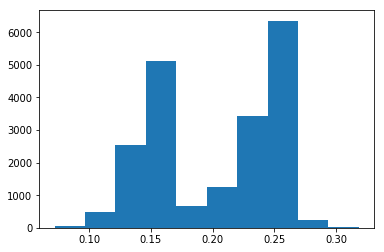

In [32]:
temp = results.predict(X)

plt.hist(temp.values)

(array([  4.00000000e+00,   7.20000000e+01,   2.53000000e+02,
          6.32000000e+02,   1.85300000e+03,   4.06000000e+03,
          1.20600000e+03,   1.40000000e+02,   2.90000000e+01,
          7.00000000e+00]),
 array([ 0.0718887 ,  0.08646945,  0.10105021,  0.11563096,  0.13021172,
         0.14479247,  0.15937323,  0.17395398,  0.18853474,  0.20311549,
         0.21769625]),
 <a list of 10 Patch objects>)

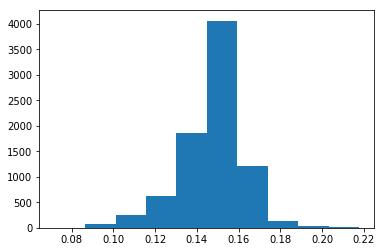

In [33]:
temp = results.predict(X[X.P==1])
plt.hist(temp.values)